In [2]:
import pandas as pd
import os
import numpy as np
import sys
import timeit
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
#rcParams['font.family'] =  'Arial' # font Arial
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [4]:
def split_get_n(data,character,n):
    result = data.str.split(f'{character}',expand=True).iloc[:,n]
    return result

In [9]:
path = '/data1/HOMO_PANGENOME/DYY/data/fusion_gene/1/'
files = os.listdir(path)
files = [x for x in files if x[-3:]=='txt']
convert = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/mstrg_ensg_transcript.csv',sep='\t')
group = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/group.csv',sep='\t')
# fusion_dict = {}
tumor_fusion_data = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/TumorFusion/nar-02671-data-e-2017-File007.csv')
# for f in files:
#     data = pd.read_csv(path+f,sep=' ',header=None)
#     fusion_dict[f[:-16]] = data

## some trying

In [290]:
group[group.name=='A1901742PD1TT2']

,name,Sample ID,Type,Sample,Group
247,A1901742PD1TT2,BLA18,Tumor,BLA,Tumor-BLA


同一个组织tumor中的fusion gene过滤掉normal中的 （filter fusions in normal samples

In [174]:
from operator import itemgetter

In [192]:
fusion_gene_dict = {}
drop_df = pd.DataFrame()
for tissue in group.Sample.drop_duplicates():
    samples = group.loc[group.Sample==tissue][['name','Sample ID']].sort_values('name')
    fusion_gene_df = pd.DataFrame()
    for key,value in samples.groupby('Sample ID'):
        normal_sample = value.name.tolist()[0]
        tumor_sample = value.name.tolist()[1]
        normal = True
        tumor = True
        try:
            fusion_normal = fusion_dict[normal_sample]
        except:
            normal = False
            print(f'there is no fusion gene in {normal_sample}')
        try:
            fusion_tumor = fusion_dict[tumor_sample]
        except:
            tumor = False
            print(f'there is no fusion gene in {tumor_sample}')
        if normal&tumor:
            fusion_gene = pd.DataFrame(set(fusion_tumor[1])-set(fusion_normal[1])) ##tumor中有但是normal中没有的fusion gene
            drop_df.loc[key,['tum','nor','Diff']] = [len(fusion_tumor), len(fusion_normal), len(fusion_gene)]
        else:
            print(f'{key} error!')
        fusion_gene_df = pd.concat([fusion_gene_df,fusion_gene])
    fusion_gene_dict[tissue] = fusion_gene_df

there is no fusion gene in A1603229D09TN1
STO9 error!
there is no fusion gene in A1702266J10TN1
CER10 error!
there is no fusion gene in A1901952D19TN2
LIV13 error!
there is no fusion gene in A1902009D19TT1
LIV15 error!
there is no fusion gene in A2000949D19TN1
LIV20 error!


In [376]:
def xlsx_to_csv_pd():
    data_xls = pd.read_excel('/data1/HOMO_PANGENOME/DYY/jaffal/group.xlsx', index_col=0)
    data_xls.to_csv('/data1/HOMO_PANGENOME/DYY/jaffal/group.csv', encoding='utf-8')


if __name__ == '__main__':
    xlsx_to_csv_pd()

## read data

In [5]:
new_group = pd.read_csv('/data1/HOMO_PANGENOME/DYY/jaffal/group.csv',header=None)
convert_dict={'renal':'KID','rectal':'REC','lung':'LUN','liver':'LIV','gastric':'STO','endometrium':'END','colon':'COL','cervical':'CER','breast':'BRE','bladder':'BLA'}
new_group = new_group.replace(convert_dict)
new_group = new_group.drop(new_group.loc[new_group[0].isin(['A1803952PD1TT3','A1923614NC','A1901741PD1TN3'])].index)

check whether paired

In [6]:
for t in new_group[2].drop_duplicates():
    test_normal = new_group[(new_group[1]=='Normal') & (new_group[2]==t)]
    test_tumor = new_group[(new_group[1]=='Tumor') & (new_group[2]==t)]
    if len(test_normal)!=len(test_tumor):
        print(f'error in pair in {t}')

In [7]:
new_group_normal = new_group.loc[new_group[1]=='Normal']
result_path = '/data1/HOMO_PANGENOME/DYY/jaffal/jaffa.result/'

## raw data (filter potential trans splicing events

In [8]:
raw_fusion_gene = {}
for g in new_group[new_group[1]=='Tumor'][0]:
    raw = pd.read_csv(result_path+g+'.jaffa_results.csv')
    raw = raw[raw['classification']!='PotentialTransSplicing']
    raw_fusion_gene[g] = raw

all raw fusion gene (after drop duplicates)

In [9]:
test = pd.concat(raw_fusion_gene.values())

In [10]:
test = test[~test['sample'].isin(drop_list)]

NameError: name 'drop_list' is not defined

In [108]:
len(drop_list)

38

In [109]:
samples_count

4

In [107]:
len(test.drop_duplicates('sample'))

155

In [106]:
len(test.drop_duplicates(['fusion genes','base1','base2']))

8633

## Only filtered potential trans splicing and germline events

In [12]:
fusion_gene_dict = {}
normal_fusion_dict = {}
empty_fg = []
for t in new_group[2].drop_duplicates():
    t_normal = new_group_normal.loc[new_group_normal[2]==t][0]
    t_tumor = new_group.loc[(new_group[1]=='Tumor') & (new_group[2]==t)][0]
    normal_fusion_gene = pd.DataFrame()
    for n in t_normal:
        # try:
        normal = pd.read_csv(result_path+n+'.jaffa_results.csv')
        # except:
        #     print(f'No result {n}')
        normal_fusion_gene = pd.concat([normal_fusion_gene,normal])
    normal_fusion_dict[t] = normal_fusion_gene
    normal_set = normal_fusion_gene['fusion genes'].drop_duplicates().tolist()
    tissue_tumor = {key: value for key, value in raw_fusion_gene.items() if key in list(t_tumor)}
    tissue_tumor = pd.concat(tissue_tumor.values()).reset_index(drop=True)
    tissue_tumor = tissue_tumor.loc[~tissue_tumor['fusion genes'].isin(normal_set)]
    # tumor_fusion_gene = tumor_fusion_gene.loc[~tumor_fusion_gene['fusion genes'].isin(normal_set)]
    # freq_df = tumor_fusion_gene[tumor_fusion_gene.duplicated('fusion genes',keep=False)].groupby('fusion genes').count()[['sample']].reset_index().rename(columns={'sample':'tissue_count'})
    # freq_df = tumor_fusion_gene.groupby('fusion genes').count()[['sample']].reset_index().rename(columns={'sample':'tissue_count'})
    # tumor_fusion_gene = tumor_fusion_gene.drop_duplicates('fusion genes').merge(freq_df,on='fusion genes',how='outer').fillna(1)
    # tumor_fusion_gene = tumor_fusion_gene.drop_duplicates('fusion genes').merge(freq_df,on='fusion genes')
    # tumor_fusion_gene.loc[:,'tissue_freq'] = tumor_fusion_gene['tissue_count']/len(t_normal)
    tissue_tumor.loc[:,'tissue'] = t
    fusion_gene_dict[t] = tissue_tumor

In [13]:
all_fusion_gene = pd.concat(fusion_gene_dict.values()).reset_index(drop=True)
len(all_fusion_gene.drop_duplicates('fusion genes'))

7128

In [11]:
drop_list = group[group['Sample ID'].isin(['LUN18','KID17','KID1','LIV4','CER2','CER7','CER3','STO2','STO4','STO6','STO11','STO12','STO13','END2','END4','COL14','COL8','COL4','COL5'])]['name'].tolist()

In [14]:
drop_list = [x+'.qc' for x in drop_list]

In [17]:
protein_coding_fusion_gene = protein_coding_fusion_gene[~protein_coding_fusion_gene['sample'].isin(drop_list)]

In [88]:
protein_coding_fusion_gene.drop_duplicates('sample')

,sample,fusion genes,chrom1,base1,strand1,chrom2,base2,strand2,gap (kb),spanning pairs,spanning reads,inframe,aligns,rearrangement,contig,contig break,classification,known,tissue
26,A2102503rccTT1.qc,ZNF879:RSRC1,chr5,179028127,+,chr3,158460935,+,inf,0,3,True,True,True,83919edd-d048-479c-8af2-ee0480b84e69,2113,HighConfidence,-,KID
39,A2102504rccTT1.qc,SLC5A1:WFDC2,chr22,32099238,+,chr20,45470451,+,inf,0,2,NaN,False,True,7e15a13d-8916-4658-924c-d518328bf246,526,LowConfidence,-,KID
40,A2102505rccTT1.qc,FAM3C:CADPS2,chr7,121396162,-,chr7,122663569,-,1267.405,0,2,False,True,True,2af8c545-97f0-49c1-804f-331c989d0347,204,HighConfidence,Yes,KID
57,A2102506rccTT1.qc,SPRY4:CAST,chr5,142324844,-,chr5,96675539,+,45649.306,0,2,False,True,True,9fe91a3f-7520-4431-a0de-e2b2aafa882f,254,HighConfidence,-,KID
68,A2102507rccTT1.qc,NLK:AATF,chr17,28172618,+,chr17,37056601,+,8883.987,0,2,False,True,False,30e2fb17-3748-4985-9954-62912291e167,406,HighConfidence,-,KID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,A1901254PD1TT3.qc,THRAP3:SFPQ,chr1,36259484,+,chr1,35188090,-,1071.392,0,2,False,True,True,983437ef-eb39-487e-8dea-a85959cf405d,237,HighConfidence,-,BLA
4278,A1901739PD1TT3.qc,C7orf50:SUN1,chr7,1127257,-,chr7,865952,+,261.306,0,3,False,True,True,107009b7-5886-417c-86dc-f084e444cfa4,254,HighConfidence,-,BLA
4306,A1901740PD1TT2.qc,CNBP:CSNK1A1,chr3,129183776,-,chr5,149525171,-,inf,0,3,False,True,True,262b16ba-87f7-44e4-ac4c-32325b52b935,216,HighConfidence,-,BLA
4337,A1901742PD1TT2.qc,PSMA3:ACTR10,chr14,58247832,+,chr14,58234370,+,13.459,0,26,False,True,True,02fd92fa-c00c-4942-8883-8b70b3b0e5d9,553,HighConfidence,Yes,BLA


### whether filter inframe genes

In [201]:
all_fusion_gene = all_fusion_gene[(all_fusion_gene.inframe!=False) | (all_fusion_gene.known=='Yes')]

### In 3 samples not found fusion events

In [145]:
new_group_normal = new_group_normal[~new_group_normal[0].isin(drop_list)]

In [146]:
sample={}
for t in new_group[2].drop_duplicates():
    t_normal = new_group_normal.loc[new_group_normal[2]==t][0]
    sample[t] = len(t_normal)

In [157]:
filtered_fusion_gene_dict = {}
for t in new_group[2].drop_duplicates():
    if t =='STO':
        filtered_data = pd.read_csv(f'/data1/HOMO_PANGENOME/DYY/data/fusion_gene/jaffa.filter/{t}.csv', sep='\t',header = None)
    else:
        filtered_data = pd.read_csv(f'/data1/HOMO_PANGENOME/DYY/data/fusion_gene/jaffa.filter/{t}.csv', sep='\t')
    filtered_fusion_gene_dict[t] = filtered_data
    # print(filtered_data.head())

In [158]:
filtered_fusion_gene_dict['STO'].columns=filtered_data.columns

In [159]:
filtered_fusion_gene = pd.concat(filtered_fusion_gene_dict.values())

In [127]:
all_fusion_gene = filtered_fusion_gene.copy()

## grep gene inframe

In [163]:
len(filtered_fusion_gene)

7294

In [161]:
inframe_fusion_gene = filtered_fusion_gene[filtered_fusion_gene.inframe==True]

In [358]:
inframe_fusion_gene.loc[:,'gene1'] = split_get_n(inframe_fusion_gene['fusion genes'],':',0)
inframe_fusion_gene.loc[:,'gene2'] = split_get_n(inframe_fusion_gene['fusion genes'],':',1)
inframe_fusion_gene.loc[inframe_fusion_gene.gene1.isin(protein_coding_gene_name[1]),'gene1_protein_coding'] = True
inframe_fusion_gene.loc[inframe_fusion_gene.gene2.isin(protein_coding_gene_name[1]),'gene2_protein_coding'] = True
inframe_fusion_gene = inframe_fusion_gene[(inframe_fusion_gene.gene1_protein_coding==True) & (inframe_fusion_gene.gene2_protein_coding==True)]

## grep protein coding genes in gencode

In [409]:
gencode = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/gencode.pro_coding.gtf', sep='\t', header=None)

In [410]:
gencode = gencode[gencode[2]=='gene']

In [416]:
protein_coding_gene_name = pd.DataFrame(split_get_n(split_get_n(gencode[8],';',2),'"',1)).reset_index(drop=True)
protein_coding_gene_name = protein_coding_gene_name[~protein_coding_gene_name[1].apply(lambda x:x[:3]=='ENS')]
all_fusion_gene.loc[:,'gene1'] = split_get_n(all_fusion_gene['fusion genes'],':',0)
all_fusion_gene.loc[:,'gene2'] = split_get_n(all_fusion_gene['fusion genes'],':',1)
all_fusion_gene.loc[all_fusion_gene.gene1.isin(protein_coding_gene_name[1]),'gene1_protein_coding'] = True
all_fusion_gene.loc[all_fusion_gene.gene2.isin(protein_coding_gene_name[1]),'gene2_protein_coding'] = True
protein_coding_fusion_gene = all_fusion_gene[(all_fusion_gene.gene1_protein_coding==True) & (all_fusion_gene.gene2_protein_coding==True)].drop(['gene1','gene2','gene1_protein_coding','gene2_protein_coding'], axis=1)

In [183]:
protein_coding_fusion_gene.to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/1122protein_coding_fusion_gene.csv',sep='\t',index=False)

In [12]:
protein_coding_fusion_gene = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/1122protein_coding_fusion_gene.csv',sep='\t')

In [179]:
extract_id = protein_coding_fusion_gene['contig'].tolist()
with open ('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/extract_ids.txt','w') as k:
    for contig in extract_id:
        k.write(f'{contig}\n')

In [180]:
len(extract_id)

3994

### inframe protein coding genes 371

In [207]:
test = protein_coding_fusion_gene.drop_duplicates('fusion genes')

In [208]:
test[test.inframe==True].to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/protein_coding_fusion_gene_inframe.csv',sep='\t',index=False)

# 4b

## same fusion transcirpts in different samples

In [19]:
len(protein_coding_fusion_gene)

3994

In [148]:
recurrent_trans_by_tissue = {}
for k,v in protein_coding_fusion_gene.groupby('tissue'):
    # v = v.drop_duplicates('fusion genes')
    recurrent_trans_by_tissue[k] = len(v)
    # break
recurrent_trans_df = pd.DataFrame.from_dict(recurrent_trans_by_tissue,orient='index').rename(columns={0:'dif_trans_count'})
recurrent_trans_df = pd.DataFrame.from_dict(sample,orient='index').reset_index().rename(columns={'index':'tissue'}).merge(recurrent_trans_df.reset_index().rename(columns={"index":"tissue"}), on='tissue')
recurrent_trans_df = recurrent_trans_df.rename(columns={0:'sample_counts'})
recurrent_trans_df.loc[:,'dif_trans_ratio'] = recurrent_trans_df.dif_trans_count/recurrent_trans_df.sample_counts

In [190]:
recurrent_trans_by_sample = {}
for k,v in protein_coding_fusion_gene.groupby('sample'):
    # v = v.drop_duplicates('fusion genes')
    recurrent_trans_by_sample[k] = len(v)
    # break
recurrent_trans_sdf = pd.DataFrame.from_dict(recurrent_trans_by_sample,orient='index').rename(columns={0:'dif_trans_count'})
# recurrent_trans_sdf = pd.DataFrame.from_dict(sample,orient='index').reset_index().rename(columns={'index':'sample'}).merge(recurrent_trans_sdf.reset_index().rename(columns={"index":"tissue"}), on='tissue')
# recurrent_trans_sdf = recurrent_trans_sdf.rename(columns={0:'sample_counts'})
recurrent_trans_sdf = recurrent_trans_sdf.reset_index().rename(columns={'index':'name'})
recurrent_trans_sdf['name'] = recurrent_trans_sdf['name'].str.split('.', expand=True).iloc[:,0]

In [191]:
plot_recurrent_trans_sdf = recurrent_trans_sdf.merge(group[['name','Sample']])
plot_recurrent_trans_sdf = plot_recurrent_trans_sdf.sort_values('Sample')

In [198]:
drop_discrete.to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/rec_trans_per_sample',sep='\t',index=False),

(None,)

In [196]:
discrete_sample = ['A2102514rccTT1','A2102919rccTT1','A1702303J11TT1','A1901742PD1TT2','A1900134PD1TT3','A1701436J01TT1','A1300829D15TT1','A1300690D15TT1','A1700656E05TT1','A1300950D16TT1']

In [197]:
drop_discrete = plot_recurrent_trans_sdf[~plot_recurrent_trans_sdf['name'].isin(discrete_sample)]

In [174]:
drop_discrete.to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/filtered_rec_trans_per_sample.csv',sep='\t',index=False)

In [5]:
drop_discrete = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/rec_trans_per_sample.csv',sep='\t')

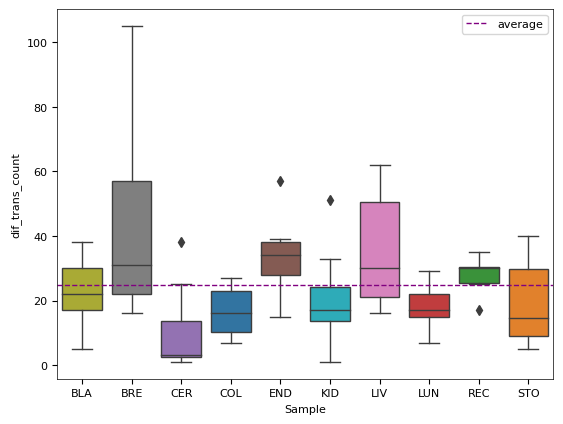

In [180]:
# sns.boxplot(plot_recurrent_trans_sdf['Sample'], plot_recurrent_trans_sdf['dif_trans_count'],palette=colors)
sns.boxplot(drop_discrete,x='Sample',y='dif_trans_count',palette=colors)
plt.hlines(xmin=-0.5,xmax=9.5,y=drop_discrete.dif_trans_count.mean(),color='purple',linestyles='--',label='average')
plt.legend()
plt.savefig('/data1/HOMO_PANGENOME/DYY/plot/11.20_135samples_boxplot_dif_trans_count_per_sample_by_tissue.pdf',dpi=400,bbox_inches='tight')

In [226]:
test = drop_discrete[drop_discrete.dif_trans_count>drop_discrete.dif_trans_count.mean()].groupby('Sample').count()[['name']]

In [231]:
from scipy.stats import chi2_contingency

In [241]:
def chi2(count,all_count):
    p = chi2_contingency([[count,(all_count-count)],[(58-count),(100-all_count+count)]])[1]
    return p

In [252]:
def chi2_(count,all_count):
    p = chi2_contingency([[count,(all_count-count)],[58,100]])[1]
    return p

In [179]:
samples_count_dict = {}
for t in protein_coding_fusion_gene['tissue'].drop_duplicates():
    samples_count_data = protein_coding_fusion_gene[protein_coding_fusion_gene['tissue']==t].drop_duplicates(['sample','fusion genes']).groupby('fusion genes').count().sort_values('sample')[['sample']]
    samples_count_data = samples_count_data[samples_count_data['sample']>1]
    samples_count = len(protein_coding_fusion_gene[(protein_coding_fusion_gene['fusion genes'].isin(samples_count_data.index.tolist())) & (protein_coding_fusion_gene.tissue==t)][['sample']].drop_duplicates())
    samples_count_dict[t] = samples_count

In [480]:
pd.concat(samples_count_dict).to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/recurrent_trans_by_samples_by_tissue.csv',sep='\t')

In [8]:
samples_count = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/recurrent_trans_by_samples_by_tissue.csv',sep='\t',index_col=0)

In [209]:
# same_tis_df = pd.DataFrame()
dif_tis_df = pd.DataFrame()
recurrent_fusion_trans = pd.DataFrame()
for k,v in protein_coding_fusion_gene.groupby('fusion genes'):
    if len(v)>1:
        tis_data = pd.DataFrame(v)
        # if (len(tis_data.tissue.drop_duplicates())==1) & (len(tis_data['sample'].drop_duplicates())>1):
        #     same_tis_df = pd.concat([same_tis_df,tis_data])
        # elif len(tis_data.tissue.drop_duplicates())>1:
        #     dif_tis_df = pd.concat([dif_tis_df,tis_data])
        if len(tis_data['sample'].drop_duplicates())>1 :
            tis_data = tis_data.drop_duplicates('sample')
            recurrent_fusion_trans = pd.concat([recurrent_fusion_trans,tis_data])
            if len(tis_data.tissue.drop_duplicates())>1:
                dif_tis_df = pd.concat([dif_tis_df,tis_data])

## sanger seq

In [131]:
sangers = os.listdir('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/Sanger.seq/fusion.gene_Sanger.seq/')
sangers = [x for x in sangers if x[-3:]=='out']
sangers = pd.DataFrame(sangers)

In [132]:
sanger = pd.DataFrame.from_dict({'gene1':split_get_n(sangers[0],'_',0),'gene2':split_get_n(sangers[0],'_',1)})

In [134]:
sanger.loc[5,'gene1'] = 'ARMCX5'
sanger.loc[5,'gene2'] = 'GPRASP2'


In [120]:
test = pd.concat(raw_fusion_gene.values())

###  in the same tissue calculate samples

In [22]:
same_tis_counts = pd.DataFrame(same_tis_df.groupby('fusion genes')['sample'].nunique()).reset_index().rename(columns={'sample':'sample_counts'})
same_tis = pd.merge(same_tis_df,same_tis_counts)
same = same_tis.sort_values(['tissue','known'], ascending=False).drop_duplicates('fusion genes')[['tissue','fusion genes','sample_counts','known']].sort_values('tissue').reset_index(drop=True)
same = same.drop('known', axis=1)
same.loc[:,'sums'] = same.replace(sample)['tissue']
same.loc[:,'percentage'] = same.sample_counts/same['sums']
same = same.set_index(['tissue','fusion genes'])['sample_counts'].unstack().T.fillna(0)
same.loc[:,'ALL'] = same.sum(axis=1)

In [25]:
same.to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/recurrent_fusion_transcirpts_in_dif_samples_in_same_tissue.csv', sep='\t',index=False)

### across different tissues

In [23]:
dif = pd.DataFrame(dif_tis_df.groupby(['fusion genes','tissue'])['sample'].nunique()).unstack().fillna(0)
dif.loc[:,'ALL'] = dif.sum(axis=1)

In [29]:
dif.sort_index().to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/recurrent_fusion_transcirpts_in_different_tissue.csv', sep='\t')

## fusion with same gene plot

In [23]:
pal = sns.color_palette(palette='tab10')
lut = dict(zip(list(group['Sample'].unique()), pal))
# Convert the palette to vectors that will be drawn on the side of the matrix
networks = plot_df.columns.tolist()
colors = pd.Series(networks, index=plot_df.columns).map(lut)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

### data

#### compare with jaffal db

In [26]:
len(protein_coding_fusion_gene.drop_duplicates('fusion genes'))

4236

In [27]:
len(protein_coding_fusion_gene[protein_coding_fusion_gene.known=='Yes'].drop_duplicates('fusion genes'))

108

#### compare with tumorfusion db

In [194]:
tf_db_gene = tumor_fusion_data['Gene_A'].tolist()
tf_db_gene = tf_db_gene + tumor_fusion_data['Gene_B'].tolist()
jaffa_gene = split_get_n(protein_coding_fusion_gene['fusion genes'],':',0).tolist()
jaffa_gene = jaffa_gene + split_get_n(protein_coding_fusion_gene['fusion genes'],':',1).tolist()

In [195]:
len(pd.DataFrame(tf_db_gene).drop_duplicates().merge(pd.DataFrame(jaffa_gene).drop_duplicates()))

2985

In [323]:
len(pd.DataFrame(jaffa_gene).drop_duplicates())

4137

### protein coding fusion genes

#### recrrent fusion transcripts

In [210]:
rec_trans = recurrent_fusion_trans[['fusion genes','sample','tissue']].groupby(['fusion genes','tissue']).count().unstack()
rec_trans.loc[:,'sums'] = rec_trans.sum(axis=1)
rec_trans = rec_trans.sort_values('sums',ascending=False).drop('sums',axis=1)
rec_trans = rec_trans.T.reset_index().drop('level_0', axis=1).set_index('tissue').T
rec_trans.fillna(0)

rec_trans.to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/recurrent_fusion_transcirpts.csv',sep='\t')

In [10]:
rec_trans = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/recurrent_fusion_transcirpts.csv',sep='\t',index_col=0)

In [21]:
plot_df = rec_trans[rec_trans.sum(axis=1)>2]
# plot_df = plot_df.T.reset_index().drop('level_0', axis=1).set_index('tissue').T

In [360]:
test = pd.DataFrame(rec_trans.sum())
test1 = pd.DataFrame.from_dict(sample,orient='index').reset_index().rename(columns={'index':'tissue'})#.merge(test.reset_index(), on='tissue')
# test1.loc[:,'recurrent_genes_per_sample'] = test1['0_y']/test1['0_x']
# test1 = test1.rename(columns={'0_x':'all_samples',"0_y":'recurrent_genes'})

In [370]:
recurrent_trans_df = recurrent_trans_df.merge(test.reset_index()).rename(columns={0:'rec_trans_count'})
recurrent_trans_df.loc[:,'rec_trans_ratio'] = recurrent_trans_df.rec_trans_count/recurrent_trans_df.sample_counts

In [30]:
from pyecharts.charts import  Sankey
from pyecharts import options as opts
from pyecharts.render import make_snapshot
# from snapshot_selenium import snapshot

In [37]:
import random

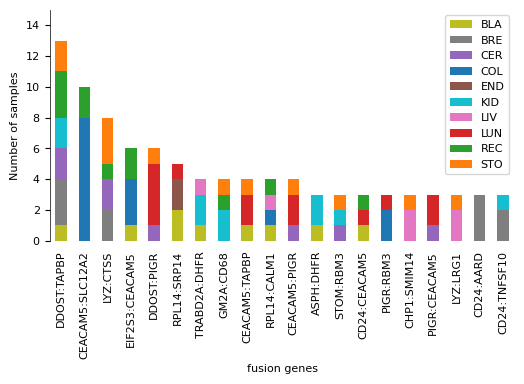

In [29]:
ax = plot_df.plot(kind='bar', stacked=True, color=colors, figsize=(6,3))
# plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, top=False, right=False)
# ax.yaxis.set_major_locator(y_major_locator)
plt.ylim(0,15)
# plt.axis('off')
plt.ylabel('Number of samples')
plt.savefig('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/protein_coding_recurrent_fusion_transcripts.pdf',bbox_inches='tight',format='pdf')

In [53]:
test = protein_coding_fusion_gene[['fusion genes','sample','tissue']].groupby(['fusion genes','tissue']).count().unstack()
test.loc[:,'sums'] = test.sum(axis=1)
test = test.sort_values('sums',ascending=False).drop('sums',axis=1)
test = test.T.reset_index().drop('level_0', axis=1).set_index('tissue').T
test.fillna(0)

tissue,BLA,BRE,CER,COL,END,KID,LIV,LUN,REC,STO
fusion genes,,,,,,,,,,
DDOST:TAPBP,1.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,3.0,2.0
CEACAM5:SLC12A2,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,4.0,0.0
LYZ:CTSS,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
DDOST:PIGR,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0
EIF2S3:CEACAM5,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
FRMD4A:DEGS1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
FRMD4B:SUCLG2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRMD5:AVEN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4c

In [54]:
rec_count_df = rec_trans.copy().fillna(0)
rec_count_df = rec_count_df.applymap(lambda x: 1 if x != 0 else 0)
rec_count_df.loc[:,'tissues'] = rec_count_df.sum(axis=1)
df = pd.DataFrame(columns=rec_count_df.columns.tolist()[:-1])
for t in df.columns.tolist():
    for i in range(6):
        df.loc[f'{i+1} same fusion',t] = len(rec_count_df[(rec_count_df[t]==1) & (rec_count_df.tissues-test[t]==i)])

In [56]:
plot_dict = {}
for t in df.columns.tolist():
    plot_dict[t] = rec_trans[rec_trans[t]>=1].index.tolist()

In [58]:
from upsetplot import from_contents
from upsetplot import plot
from upsetplot import generate_counts, UpSet

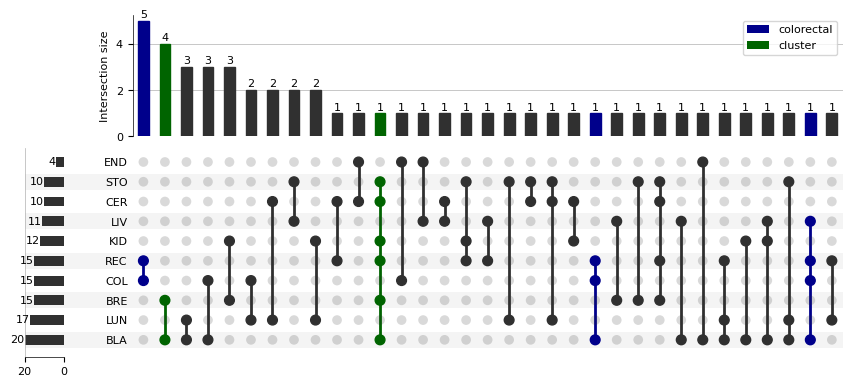

In [199]:
upset = UpSet(from_contents(plot_dict),min_degree=2, element_size = 20, sort_by='cardinality',  show_counts=True, facecolor='#303030')
upset.style_subsets(present=["COL", "REC"],
                    facecolor="darkblue",
                    label="colorectal")
upset.style_subsets(present=["BRE",'BLA'],
                    facecolor="darkgreen",
                    label="cluster")
upset.plot()
# plt.show()
plt.savefig('/data1/HOMO_PANGENOME/DYY/plot/121upset_rec_trans_intersect.pdf', bbox_inches = 'tight', dpi=400)

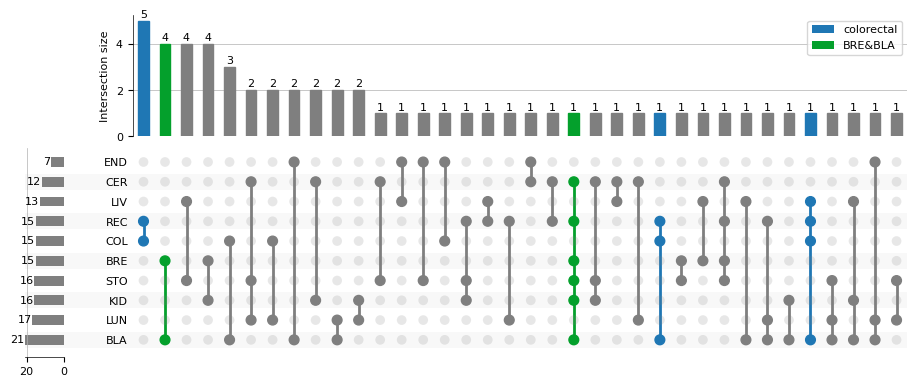

In [76]:
upset = UpSet(from_contents(plot_dict),min_degree=2, element_size = 20, sort_by='cardinality',  show_counts=True, facecolor='#7f7f7f')
upset.style_subsets(present=["COL", "REC"],
                    facecolor="#1f77b4",
                    label="colorectal")
upset.style_subsets(present=["BRE",'BLA'],
                    facecolor="#04a02c",
                    label="BRE&BLA")
upset.plot()
plt.savefig('/data1/HOMO_PANGENOME/DYY/plot/13upset_rec_trans_intersect.pdf', bbox_inches = 'tight', dpi=400)

In [185]:
len(rec_trans[rec_trans.sum(axis=1)==2])

48

In [186]:
len(rec_trans[rec_trans.count(axis=1)>=2])

50

# 4e f

#### fusion partner genes

In [13]:
protein_coding_fusion_gene.loc[:,'gene1'] = split_get_n(protein_coding_fusion_gene['fusion genes'],':',0)
protein_coding_fusion_gene.loc[:,'gene2'] = split_get_n(protein_coding_fusion_gene['fusion genes'],':',1)
gene1 = protein_coding_fusion_gene[['gene1','tissue','sample']].rename(columns={'gene1':'gene'}).drop_duplicates(['gene','sample'])
gene2 = protein_coding_fusion_gene[['gene2','tissue','sample']].rename(columns={'gene2':'gene'}).drop_duplicates(['gene','sample'])
concat_df = pd.concat([gene1,gene2]).groupby(['gene', 'tissue']).count().unstack()
# concat_df = concat_df[concat_df.count(axis=1)>1]

In [14]:
len(concat_df)

4137

In [287]:
pd.DataFrame(concat_df.index.tolist()).to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/recurrent_fusion_genes_for_go_and_kegg.csv',sep='\t', index=False)

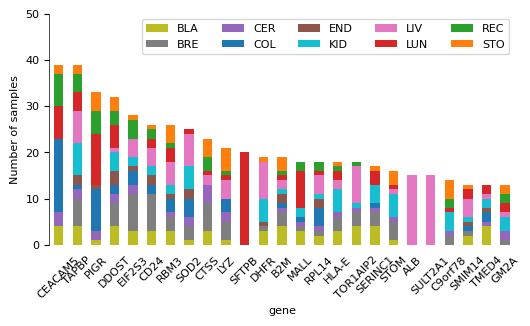

In [337]:
concat_df.loc[:,'sums'] = concat_df.sum(axis=1)
concat_df = concat_df[concat_df['sums']>1]
concat_df = concat_df.sort_values('sums',ascending=False).drop('sums',axis=1)
plot_df = concat_df.head(25)
plot_df = plot_df.T.reset_index().drop('level_0', axis=1).set_index('tissue').T
ax = plot_df.plot(kind='bar', stacked=True, color=colors, figsize=(6,3))
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, top=False, right=False)
# ax.yaxis.set_major_locator(y_major_locator)
plt.ylim(0,50)
# plt.axis('off')
plt.ylabel('Number of samples')
plt.legend(loc='best',
           # bbox_to_anchor=(1.0,1.0), 
           ncol=5)
# plt.savefig('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/11.20_protein_coding_recurrent_genes.pdf', bbox_inches='tight',dpi=400)

#### partner genes in recurrent transcripts

In [332]:
rec_concat_df.loc[:,'sums'] = rec_concat_df.sum(axis=1)
rec_concat_df = rec_concat_df[rec_concat_df['sums']>2]
rec_concat_df = rec_concat_df.sort_values('sums',ascending=False).drop('sums',axis=1)
# plot_df = concat_df.head(25)
rec_plot_df = rec_concat_df.head(22)
# plot_df = plot_df.T.reset_index().drop('level_0', axis=1).set_index('tissue').T

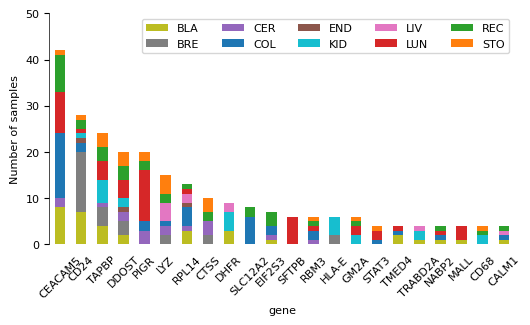

In [333]:
# plt.figure(figsize=(15,8))
ax = rec_plot_df.plot(kind='bar', stacked=True, color=colors, figsize=(6,3))
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, top=False, right=False)
# ax.yaxis.set_major_locator(y_major_locator)
plt.ylim(0,50)
# plt.axis('off')
plt.ylabel('Number of samples')
plt.legend(loc='best',
           # bbox_to_anchor=(1.0,1.0), 
           ncol=5)
# plt.show()
plt.savefig('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/11.21_protein_coding_recurrent_trans_genes.pdf', bbox_inches='tight',dpi=400)

#### pie plot of all trans

In [424]:
all_fusion = protein_coding_fusion_gene.drop_duplicates('fusion genes')
len(all_fusion)

3831

In [388]:
inter_with_tf = set(tumor_fusion_data.Gene_A+':'+tumor_fusion_data.Gene_B).intersection(set(all_fusion['fusion genes']))
len(inter_with_tf)

45

In [389]:
remain_fusion = all_fusion[~all_fusion['fusion genes'].isin(inter_with_tf)]

In [392]:
inter_with_jl = remain_fusion[remain_fusion.known=='Yes'][['fusion genes']]
len(inter_with_jl)

52

In [399]:
remain = remain_fusion[remain_fusion.known!='Yes']
len(remain)

3734

In [401]:
abs_novel = remain[~(remain.gene1.isin(tf_db_gene) | (remain.gene2.isin(tf_db_gene)))]

In [425]:
both_known = remain[(remain.gene1.isin(tf_db_gene) & (remain.gene2.isin(tf_db_gene)))]

In [427]:
len(remain[(remain.gene1.isin(tf_db_gene) | (remain.gene2.isin(tf_db_gene)))])

3398

In [426]:
len(both_known)

1876

In [402]:
len(abs_novel)

336

In [148]:
plot_fusion_data = dif_tis_df[['fusion genes','tissue','sample']]
plot_fusion_data = plot_fusion_data.groupby(['fusion genes', 'tissue']).count().unstack()
plot_fusion_data.loc[:,'sums'] = plot_fusion_data.sum(axis=1)
plot_fusion_data = plot_fusion_data[plot_fusion_data['sums']>2]
plot_fusion_data = plot_fusion_data.sort_values('sums',ascending=False).drop('sums',axis=1)
# plot_fusion_df = plot_fusion_data.head(25)
plot_fusion_df = plot_fusion_data.T.reset_index().drop('level_0', axis=1).set_index('tissue').T

In [149]:
len(plot_fusion_df)

19

In [152]:
test = plot_fusion_df.reset_index()[['fusion genes']]
concat_test = pd.concat([split_get_n(test['fusion genes'],':',0),split_get_n(test['fusion genes'],':',1)])

In [256]:
send_fusion = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/same_fusion_dif_samples_dif_tissues.csv', sep='\t')

In [258]:
recurrent_fusion_trans[recurrent_fusion_trans['fusion genes'].isin(plot_df.index.tolist())].to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/same_fusion_at_least_3_samples_dif_tissues.csv',sep='\t')

In [271]:
test1 = recurrent_fusion_trans[recurrent_fusion_trans['fusion genes'].isin(plot_df.index.tolist())]['sample']+recurrent_fusion_trans[recurrent_fusion_trans['fusion genes'].isin(plot_df.index.tolist())]['fusion genes']

In [272]:
test2 = send_fusion['sample']+send_fusion['fusion genes']

In [277]:
test1 = pd.DataFrame(test1)
test2 = pd.DataFrame(test2)

In [870]:
filtered_dict = {}
for t in new_group[2].drop_duplicates():
    tumor = fusion_gene_dict[t].reset_index(drop=True)
    ##inframe & rearrangement
    # tumor = tumor[((tumor.inframe!=False) & (tumor.rearrangement==True)) | (tumor.known=='Yes')]
    tumor = tumor.set_index('sample').drop_duplicates(['fusion genes','base1','base2','contig'])
    filtered_dict[t] = tumor
    # break

In [891]:
all_filter_gene = pd.concat(filtered_dict.values()).reset_index(drop=True)

In [933]:
len(all_fusion_gene.loc[all_fusion_gene.known=='Yes'])

130

In [350]:
test = protein_coding_fusion_gene.copy().reset_index(drop=True)

In [351]:
test.loc[:,'gene1'] = split_get_n(test['fusion genes'],':',0)
test.loc[:,'gene2'] = split_get_n(test['fusion genes'],':',1)

In [352]:
test0 = test.drop_duplicates('fusion genes')

In [353]:
len(test0[test0.known=='Yes'])

97

In [354]:
test.drop_duplicates('fusion genes')['known'].count()

3831

In [344]:
len(test[test.known=='Yes'])

100

In [345]:
test = test.drop(test.loc[(test.gene1.str[:3] == test.gene2.str[:3]) & (test.known!='Yes')].index)

In [355]:
test_gene = split_get_n(test['fusion genes'],':',0).tolist()
test_gene = test_gene + split_get_n(test['fusion genes'],':',1).tolist()

In [347]:
test.loc[(test.gene1.str[:3] == test.gene2.str[:3]) & (test.known!='Yes')]

,sample,fusion genes,chrom1,base1,strand1,chrom2,base2,strand2,gap (kb),spanning pairs,...,inframe,aligns,rearrangement,contig,contig break,classification,known,tissue,gene1,gene2


In [357]:
len(set(test_gene))

4137

In [837]:
all_fusion_gene[all_fusion_gene.duplicated('fusion genes', keep=False)].sort_values('fusion genes').to_csv('/data1/HOMO_PANGENOME/DYY/data/fusion_gene/duplicated_genes_across_cancers.csv',sep='\t',index=False)

In [625]:
all_freq_df = all_fusion_gene[all_fusion_gene.duplicated('fusion genes',keep=False)].groupby('fusion genes').sum().reset_index()[['fusion genes','tissue_count']].rename(columns={'tissue_count':'all_count'})
all_fusion_gene = all_fusion_gene.drop_duplicates('fusion genes').merge(all_freq_df,on='fusion genes',how='outer').fillna(1)
all_fusion_gene.loc[:,'all_freq'] = all_fusion_gene['all_count']/175

In [873]:
for k in fusion_gene_dict.keys():
    fusion_gene_dict[k].to_csv(f'/data1/HOMO_PANGENOME/DYY/data/fusion_gene/jaffal_for_filter/{k}.csv',sep='\t',index=False)
    print(len(fusion_gene_dict[k]))

1045
373
664
1193
727
546
783
590
1323
936


In [675]:
all_fusion_gene.to_csv(f'/data1/HOMO_PANGENOME/DYY/data/fusion_gene/jaffal/all_tissue.csv',sep='\t',index=False)

In [445]:
intersect_dict = {}
for tissue in group.Sample.drop_duplicates():
    fusion_filtered = fusion_gene_dict[tissue]
    tf_database = tumorfusion_dict[tissue]
    intersect_dict[tissue] = set(fusion_filtered['fusion genes']).intersection(set(tf_database['Gene_A']+':'+tf_database['Gene_B']))

In [78]:
tumorfusion_dict = {}
tumorfusion_dict['BRE'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['BRCA'])]
tumorfusion_dict['STO'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['STAD'])]
tumorfusion_dict['REC'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['READ'])]
tumorfusion_dict['LUN'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['LUAD'])]
tumorfusion_dict['CER'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['CESC'])]
tumorfusion_dict['END'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['UCEC'])]
tumorfusion_dict['LIV'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['LIHC'])]
tumorfusion_dict['COL'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['COAD'])]
tumorfusion_dict['BLA'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['BLCA'])]
tumorfusion_dict['KID'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['KIRC','KIRP','KICH'])]
# tumorfusion_dict['BRE'] = tumor_fusion_data.loc[tumor_fusion_data.Tissue.isin(['BRCA'])]

In [12]:
tumorfusion_df = pd.concat(tumorfusion_dict.values())
tumorfusion_df.loc[:,'fusion genes'] = tumorfusion_df['Gene_A']+":"+tumorfusion_df['Gene_B']

In [414]:
intersect_dict = {}
for tissue in group.Sample.drop_duplicates():
    fusion_filtered = fusion_gene_dict[tissue]
    tf_database = tumorfusion_dict[tissue]
    # print(len(pd.DataFrame(tf_database['Gene_A']+'='+tf_database['Gene_B']).drop_duplicates().merge(fusion_filtered)))
    fusion_gene_list1 = split_get_n(fusion_filtered['fusion genes'],':',0)
    fusion_gene_list2 = split_get_n(fusion_filtered['fusion genes'],':',1)
    fusion_gene_list_filtered = fusion_gene_list1.append(fusion_gene_list2)
    fusion_gene_list1 = tf_database['Gene_A']
    fusion_gene_list2 = tf_database['Gene_B']
    fusion_gene_list_tf = fusion_gene_list1.append(fusion_gene_list2)
    intersect_dict[tissue] = pd.DataFrame(set(fusion_gene_list_filtered)).merge(pd.DataFrame(set(fusion_gene_list_tf)))
    # break

In [10]:
tpm_path = '/data1/HOMO_PANGENOME/DYY/data/288_mstrg_tpm/'
tpm_files = os.listdir(tpm_path)
tpm_files = [x for x in tpm_files if x[-3:]=='csv']
for t in tpm_files:
    tpm_data = pd.read_csv(tpm_path+t,sep='\t',index_col=0)
    sample_id = tpm_data.loc[:,tpm_data.loc['Type']=='Tumor'].columns.tolist()
    tissue = t[:3]
    fusion_gene_df = pd.DataFrame()
    for s in sample_id:
        try:
            fusion_data = fusion_dict[s]
            # fusion_gene_list1 = split_get_n(fusion_data[1],'=',0)
            # fusion_gene_list2 = split_get_n(fusion_data[1],'=',1)
            # fusion_gene_list = set(fusion_gene_list1+fusion_gene_list2)
        except:
            print(f'there is no fusion gene in {s}')
            fusion_data = pd.DataFrame()
        # fusion_gene = pd.DataFrame(data=fusion_gene_list)
        fusion_gene_df = pd.concat([fusion_gene_df,fusion_data])
    # fusion_gene_df = fusion_gene_df.drop_duplicates(1)
    fusion_gene_list1 = split_get_n(fusion_gene_df[1],'=',0)
    fusion_gene_list2 = split_get_n(fusion_gene_df[1],'=',1)
    break

there is no fusion gene in A1902009D19TT1


NameError: name 'split_get_n' is not defined

In [89]:
fusion_gene = pd.concat(fusion_gene_dict).reset_index().set_index('tissue').drop(['level_0','level_1'],axis=1)
recurrent_fusion_gene = fusion_gene[fusion_gene.duplicated(['fusion genes'], keep=False)]

In [150]:
# diff_base = recurrent_fusion_gene.drop_duplicates(['fusion genes','base1'])
diff_base = recurrent_fusion_gene[~recurrent_fusion_gene['fusion genes'].str.contains('TRA')].sort_values('fusion genes')
diff_base = diff_base[~diff_base['fusion genes'].str.contains('TRB')].sort_values('fusion genes')

In [151]:
n=0
dupl_df = pd.DataFrame()
for g,r in diff_base.groupby('fusion genes'):
    if (len(r.drop_duplicates('base1'))>1) & (len(r.reset_index().drop_duplicates('tissue'))>2):
        n+=1
        dupl_df = pd.concat([dupl_df,r])
        # print(r)
        # break

In [100]:
recurrent_fusion_gene

,sample,fusion genes,chrom1,base1,strand1,chrom2,base2,strand2,gap (kb),spanning pairs,spanning reads,inframe,aligns,rearrangement,contig,contig break,classification,known
tissue,,,,,,,,,,,,,,,,,,
KID,A2102502rccTT1.qc,TRAV12-1:TRAJ9,chr14,21841768,+,chr14,22535558,+,693.790,0,8,NaN,False,False,2ae35759-02eb-4be4-8516-daa15579b54d,529,LowConfidence,-
KID,A2102502rccTT1.qc,TRAV13-1:TRAJ20,chr14,21869352,+,chr14,22524329,+,654.977,0,4,NaN,False,False,20c3c02b-a53c-413c-b0a0-34be81317a42,1171,LowConfidence,-
KID,A2102502rccTT1.qc,TRAV5:TRAJ3,chr14,21749698,+,chr14,22543185,+,793.487,0,3,NaN,False,False,a63cdc16-43fc-448f-84b5-1c464847d17d,1164,LowConfidence,-
KID,A2102502rccTT1.qc,TRAV27:TRAJ53,chr14,22148632,+,chr14,22483010,+,334.378,0,2,NaN,False,False,d77e931c-bcae-4ce0-aafd-fb4299fee35f,489,LowConfidence,-
KID,A2102502rccTT1.qc,TRAV13-1:TRAJ45,chr14,21869360,+,chr14,22493934,+,624.574,0,2,NaN,False,False,aba399c5-f342-4406-9222-d649178f9f62,1180,LowConfidence,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLA,A1901744PD1TT1.qc,TRAV3:TRAJ20,chr14,21724313,+,chr14,22524328,+,800.015,0,2,NaN,False,False,3eb5b06e-82c0-4fb9-970c-3f5d56b19cdb,600,LowConfidence,-
BLA,A1901744PD1TT1.qc,DDX5:TBCD,chr17,64506076,-,chr17,82900652,+,18394.576,0,2,NaN,False,True,39307a10-8135-4e73-a8b5-80bea6dce078,2305,LowConfidence,-
BLA,A1901744PD1TT1.qc,TAPBP:CEACAM5,chr6,33301023,-,chr19,41729457,+,inf,0,2,NaN,False,True,46c16cb6-4110-405f-a955-5b902746ee20,607,LowConfidence,-
